In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# model selection
from sklearn.model_selection import GridSearchCV

#metrics
from sklearn.metrics import precision_score, classification_report, confusion_matrix,f1_score, recall_score
from sklearn.model_selection import RepeatedStratifiedKFold

#smote 
from imblearn.over_sampling import SMOTE

# data
from sklearn.model_selection import train_test_split

#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# Data Import and Split 

In [33]:
Train = pd.read_csv(r'../data/Train_year.csv', index_col=0)
y_Train = pd.read_csv(r'../data/y_Train_year.csv', index_col= 0)

Test = pd.read_csv(r'../data/Test_year.csv', index_col= 0)
y_Test = pd.read_csv(r'../data/y_Test_year.csv', index_col= 0)

In [34]:
features = ['ADR', 'LeadTime','StaysInWeekNights', 'TotalOfSpecialRequests',
        'BookingChanges', 'PreviousBookingsNotCanceled', 'RequiredCarParkingSpaces', 'PreviousCancellations',
        'x0_BB', 'x0_SC', 'x1_A', 'x1_B', 'x1_D',
       'x1_E', 'x1_F', 'x1_G', 'x2_avg_booker', 'x2_good_booker',
       'x2_low_booker', 'x2_no_booker', 'x2_super_booker', 'x3_Autumn',
       'x3_Spring', 'x3_Summer', 'x4_Low_Season']

# Functions to Test Models 

In [35]:
def metrics(X_train, X_val, y_train, pred_train , y_val, pred_val, model):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))
    print("Score: "+ str(model.score(X_train, y_train)))
    print("F1 Score: "+ str(f1_score(y_train, pred_train)))

    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))
    print("Score: "+ str(model.score(X_val, y_val)))
    print("F1 Score: "+ str(f1_score(y_val, pred_val)))

In [59]:
def avg_score(model, data_to_slice, y_to_slice, columns_to_use, smote = True):
    # apply kfold
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    f1_list = []
    precision_list =[]
    recall_list = []
    tn_avg = 0
    fp_avg = 0
    fn_avg = 0
    tp_avg = 0
    count = 0
    for train_index, test_index in skf.split(data_to_slice[columns_to_use],y_to_slice):
        # get the indexes of the observations assigned for each partition
        X_train, X_val = data_to_slice[columns_to_use].iloc[train_index], data_to_slice[columns_to_use].iloc[test_index]
        y_train, y_val = y_to_slice.iloc[train_index], y_to_slice.iloc[test_index]
        
        # SMOTE É AQUI 
        if smote:
             
            smote = SMOTE(random_state = 11)
            X_train, y_train = smote.fit_resample(X_train, y_train)

        # applies the model 
        model_fit = model.fit(X_train, y_train)
        # predicts training 
        y_pred_train =  model_fit.predict(X_train)
        #predicts validation 
        y_pred_val = model_fit.predict(X_val)
        # prints metric results 
        
        #metrics(X_train, X_val, y_train, y_pred_train, y_val, y_pred_val, model)
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred_val).ravel()
        count += 1
        tn_avg += tn
        fp_avg += fp
        fn_avg += fn
        tp_avg += tp

        
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_val,y_val)
        f1_score_val = f1_score(y_val, y_pred_val)
        precision_val = precision_score(y_val, y_pred_val)
        recall_val = recall_score(y_val, y_pred_val)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        f1_list.append(f1_score_val)
        precision_list.append(precision_val)
        recall_list.append(recall_val)
  
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    avg_f1 = round(np.mean(f1_list),3)
    std_f1 = round(np.std(f1_list),2)
    avg_precision = round(np.mean(precision_list),3)
    std_precision = round(np.std(precision_list),2)
    avg_recall = round(np.mean(recall_list), 3)
    std_recall = round(np.mean(recall_list),2)

    tn_avg = tn_avg / count
    fp_avg = fp_avg / count
    fn_avg = fn_avg / count
    tp_avg = tp_avg / count
    #print(confusion_matrix(y_val, y_pred_val))
    print(str(tp_avg)+ ' , ' + str(fp_avg) + '\n' + str(fn_avg) + ' , ' +  str(tn_avg))
    return str(avg_train) + '+/-' + str(std_train),\
            str(avg_test) + '+/-' + str(std_test) , str(avg_f1) + '+/-' + str(std_f1), avg_f1,\
                ' Precision: ' + str(avg_precision) + '+/-' + str(std_precision), avg_precision, \
            'RECALL :'+ str(avg_recall)+ '+/-' + str(std_recall)

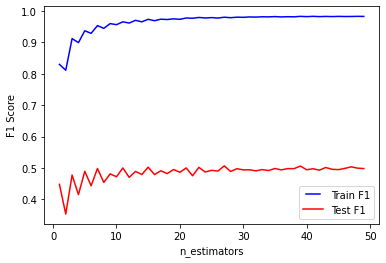

In [37]:
from matplotlib.legend_handler import HandlerLine2D
n_estimators = np.arange(1, 50)
train_results = []
test_results = []
diff=[]

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, criterion= 'gini')
    rf.fit(Train, y_Train)
    train_pred = rf.predict(Train)
    train_score = f1_score(y_Train,train_pred)
    train_results.append(train_score)
    
    test_pred = rf.predict(Test)
    val_score = f1_score(y_Test,test_pred)
    test_results.append(val_score)
    diff.append(val_score-train_score)
    
line1, = plt.plot(n_estimators, train_results, 'b', label='Train F1')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 Score')
plt.xlabel('n_estimators')
plt.show()

In [38]:
df_estimator=pd.DataFrame([pd.Series(n_estimators,name='n_estimators',dtype=int),pd.Series(train_results,name='Train'),pd.Series(test_results,name='Val'),pd.Series(diff,name='Diff')]).T
df_estimator.sort_values(by='Val',ascending=False)

,n_estimators,Train,Val,Diff
26,27.0,0.980280,0.506841,-0.473439
38,39.0,0.982950,0.506184,-0.476767
46,47.0,0.982597,0.503778,-0.478819
14,15.0,0.973629,0.502555,-0.471074
22,23.0,0.979473,0.502036,-0.477437
42,43.0,0.982769,0.501532,-0.481237
20,21.0,0.977829,0.500131,-0.477698
10,11.0,0.965552,0.500128,-0.465423
47,48.0,0.982978,0.499514,-0.483464
45,46.0,0.982474,0.498629,-0.483844


In [49]:
rf_gini = RandomForestClassifier(criterion='gini', n_estimators=25)
rf_entropy = RandomForestClassifier(criterion='entropy', n_estimators=25)

In [60]:
avg_score(rf_gini, Train, y_Train, Train.columns,True)

1116.96 , 527.76
718.24 , 4257.44


('0.993+/-0.0',
 '0.812+/-0.0',
 '0.642+/-0.01',
 0.642,
 ' Precision: 0.679+/-0.01',
 0.679,
 'RECALL :0.609+/-0.61')

In [55]:
avg_score(rf_entropy, Train, y_Train, Train.columns,True)

1112.96 , 4251.96
533.24 , 722.24


('0.993+/-0.0',
 '0.81+/-0.0',
 '0.639+/-0.01',
 0.639,
 ' Precision: 0.676+/-0.01',
 0.676,
 'RECALL :0.606+/-0.61')

In [56]:
prediction = rf_entropy.predict(Test)

In [57]:
print(prediction.sum())

print(y_Test.sum())

5594
IsCanceled    6826
dtype: int64


In [58]:
a = 0
for i,x in enumerate(y_Test.IsCanceled):
    if prediction[i] == x:
        a+=1
a

14161

Entropy looks like the best choice although both criterias are very similar. 

In [67]:
# forest params
param_grid = { 
    'max_depth' : range(5,16),
    'min_impurity_decrease' : [0.01,0.03,0.05],
    'min_samples_leaf': range(80,200,40),
    'min_samples_split':range(200,1001,300)
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_entropy, param_grid = param_grid, scoring = 'recall')

grid_search.fit(Train, y_Train)
grid_search.best_params_, grid_search.best_score_

In [62]:
rf_model = RandomForestClassifier(criterion='entropy', max_depth=13, min_impurity_decrease=0.01, min_samples_leaf=170, min_samples_split=600)

In [63]:
avg_score(rf_model, Train, y_Train, Train.columns,True)

1165.2 , 1119.48
670.0 , 3665.72


('0.731+/-0.01',
 '0.73+/-0.03',
 '0.566+/-0.01',
 0.566,
 ' Precision: 0.523+/-0.07',
 0.523,
 'RECALL :0.635+/-0.63')

In [65]:
y_test_pred = rf_model.predict(Test)

In [66]:
a = 0
for i,x in enumerate(y_Test.IsCanceled):
    if y_test_pred[i] == x:
        a+=1
a

13289